In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px 

import viral 
import embed

import warnings
warnings.filterwarnings('ignore')
# %matplotlib notebook

<module 'embed' from '/cluster/home/ajoudaki/seqCNN/embed.py'>

### Embed sequences using pre-trained model 

In [21]:
dataset, embeddings = viral.get_embedings()
edit_dists = viral.get_edit_dists(dataset)

embed_dists = embed.pairwise_embed_dist(embeddings)
data = embed.get_dataframe(dataset, edit_dists, embed_dists)
stats_summary = embed.get_stats(dataset, data)

 13%|█▎        | 8/61 [00:00<00:00, 75.18it/s]

['/cluster/work/grlab/home/ajoudaki/seqCNN/networks/seqCNN_in_channels4_num_layers8_channels1_kernel3_stride2_groups4_1623100075']


100%|██████████| 61/61 [00:00<00:00, 75.79it/s]


calculated for 15586 substrings, forming 242907694 pairs


### Sparsity of pairwise edit distance graph 

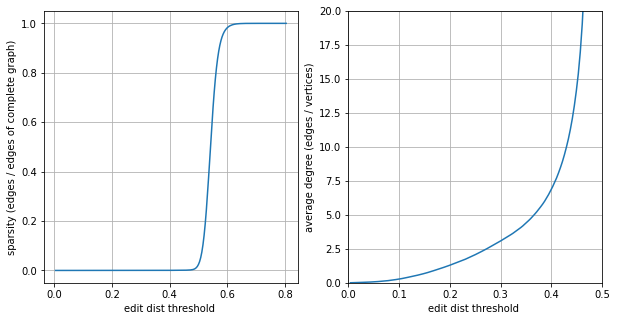

In [23]:
fig = embed.sparsity(edit_dists/dataset.L)
fig.show()

### Show sample embedding sequences 

<Figure size 504x504 with 0 Axes>

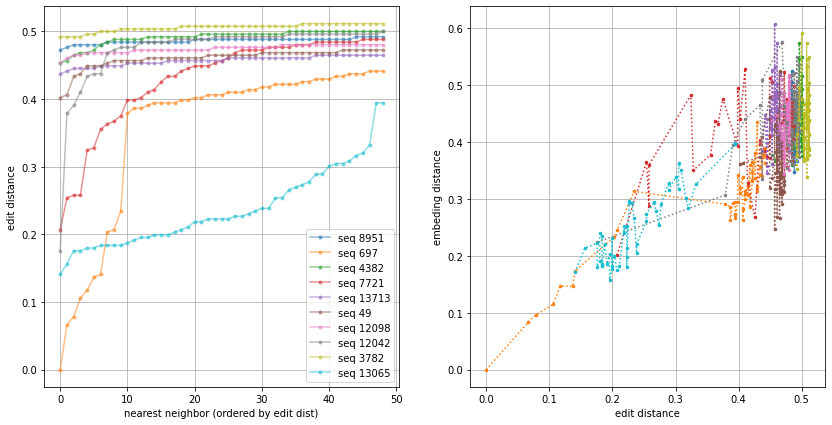

In [24]:
ed_neighbors = np.argsort(edit_dists, axis=1)
embed.sample_edit_vs_embed_dists(edit_dists/dataset.L, embed_dists, ed_neighbors)

In [26]:
random_samples = embed.get_samples(dataset, data, num_samples=20)
embed.embed_vs_ed(dataset, random_samples, x='edit dist', y='embed dist')

FigureWidget({
    'data': [{'marker': {'size': 2},
              'mode': 'markers',
              'name': 'sa…

# NN Indexing by sensitive hashing

for binary matrix $X \in R^{D\times N}$ with unit-norm columns $\|x_1\|, \dots, \|x_N\|=1$. We want to find all pairs $i,j$ such that $\|x_i-x_j\|^2\le d_1$ with $1-\delta$ probability. Furthermore, we want to retrieve at most $O(N)$ pairs with $\|x_i - x_j\|^2> d_2$. 
- Step 1: project $X$ onto binary matrix $Y$ by projection $Y = sign( G X )$ where $G \sim \mathcal{N}(0,I_{d\times D})$ is a Gaussian matrix. 
- Step 2: Compute buckets $Y^1, .., Y^M$ from $Y$ by sub-sampling $m$ columns uniformly at random 
- Step 3: retrieve all pairs $(i,j)$ that collide $y^k_i=y^k_j$s for one of the buckets $k=1,\dots, M$

Analysis: 
- if $d$ is large enough (?) we Hamming distance of $y_i$ and $y_j$ closely approximates $\|x_i - x_j\|^2$. 
- the probability of a matching sign for those above $d_2$ is at most $(1-d_2)$. Sinc we sample $m$ columns, the collision probability is at most $(1-d_2)^m$. There are at most $N^2$ such pairs. Therefore, $m = \log(N)/\log(1-d_2)$ suffices to ensure $O(N)$ pairs for each bucket.  
- For a pair below $d_1$ the collision probably is $P_1=(1-d_1)^m$, and the probability that in none of the $M$ trials we don't have a success is $(1-P_1)^M$. Therefore, by setting $M:=\log(\delta)/\log(1-P_1)$ we guarantee that in expectation $1-\delta$ percentage of the desired pairs are found. In other wordds, we have $1-\delta$ recall in expectation.  

## subsampling edit distance 

In [ ]:
%%time 

importlib.reload(viral)
importlib.reload(embed)


d1 = .3
d2 = .4
recall = .90
max_len = 1500

ed_th = .3
num_samples = 100
th = .3

# dataset, embeddings = get_embedings(max_len=max_len, num_layers=10, groups=2, kernel=5)
# sample_dists, samples = sample_edit_dist(dataset, num_samples)

# NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
# print("searching for sample data")
# index = KNN.search(NN, NN_dists, samples)

target = sample_dists/dataset.L < ed_th
recall, dist_calls = KNN.sample_PR(samples, target, index, th=th)
print("computing summary")
# df = target_summary(dataset, target, index, print_info=False, max_sh=1)

print(f"recall edit dist < {ed_th} = {recall:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}\n"
      f"edit dist calls per sample {int(dist_calls/num_samples)}\n"
      f"dataset size {len(dataset)}")


In [ ]:
plt.plot(np.sort(sample_dists[sample_dists>0])/dataset.L,np.arange(np.sum(sample_dists>0)))
# plt.xscale('log')
# plt.yscale('log')
plt.grid('on')

In [ ]:
print(len(df))
px.scatter(df, df.ed/dataset.L, y='embed_dist', hover_data=["ed_sh","sample"], color="indexed")

In [ ]:
r = np.random.randint(len(df))
r = 322
sh1,sh2 = 0,0
L = dataset.L  

i1,j1,i2,j2 = df[['id1','pos1', 'id2', 'pos2']].iloc[r]
id1,id2 = dataset.ids[i1], dataset.ids[i2]

s1, s2 = dataset.seqs[i1][j1+sh1:j1+sh1+L], dataset.seqs[i2][j2+sh2:j2+sh2+L]
print(f"{id1} | {j1} ")
print(f"{id2} | {j2} ")
seq_alignment_viewer(s1,s2,p=-1)

i1,j1,i2,j2

## all pairs analysis 

In [ ]:
%%time 

d1 = .2
d2 = .35
recall = .99
max_len = 1500
ed_th = .15

# NN, NN_dists = KNN.nn(embeddings, d1, d2, recall=recall)
# NN_dists = KNN.nn_dists(embeddings, NN)
# NN, NN_dists = KNN.nn_index(embeddings, d1, d2, recall)
# index = KNN.nn2index(NN,NN_dists)

_, recall = KNN.PR_curve(NN, embed_dists<d1)
_, recall2 = KNN.PR_curve(NN, edit_dists/dataset.L<ed_th)
print(f"recall embed dist = {recall:.5f}\n"
      f"recall edit dist = {recall2:.5f}\n"
      f"embed dist calls per sample {int(NN.shape[0]/len(dataset))}")

# len(dataset), embeddings.shape, NN.shape, NN.shape[0]/len(dataset)